In [11]:
from pykeops.torch import LazyTensor
import torch
import matplotlib.pyplot as plt

In [12]:
torch.manual_seed(0)

In [13]:
device = 'cuda:1'

In [14]:
def rand_nys_appx(K, n, r, device):
    # Calculate sketch
    Phi = torch.randn((n, r), device=device) / (n ** 0.5)
    Phi = torch.linalg.qr(Phi, mode='reduced')[0]

    Y = K @ Phi

    # Calculate shift
    shift = torch.finfo(Y.dtype).eps
    Y_shifted = Y + shift * Phi

    # Calculate Phi^T * K * Phi (w/ shift) for Cholesky
    choleskytarget = torch.mm(Phi.t(), Y_shifted)

    # Perform Cholesky decomposition
    C = torch.linalg.cholesky(choleskytarget)

    B = torch.linalg.solve_triangular(C, Y_shifted, upper=False, left=False)
    U, S, _ = torch.linalg.svd(B, full_matrices=False)

    return U, S

In [15]:
def loss(K, b, lambd, a):
    return 1/2 * torch.dot(a, K @ a) + lambd / 2 * torch.dot(a, a) \
            - torch.dot(b, a) 

In [16]:
def gd(K, b, lambd, a0, rho, eta, r, max_iter, device):
    n = K.shape[0]
    U, S = rand_nys_appx(K, n, r, device)

    print(S)

    plt.semilogy(S.cpu().numpy())
    plt.show()

    a = a0
    for i in range(max_iter):
        g = K @ a + lambd * a - b
        UTg = U.t() @ g
        dir = U @ (UTg / (S + rho)) + 1/rho * (g - U @ UTg)
        a -= eta * dir

        print(f"iter {i}, loss {loss(K, b, lambd, a)}")

    return a

In [17]:
# Example sizes
N_x = 100000  # Number of rows in x

# Generate random data
x = torch.randn(N_x, 3, dtype=torch.float32, requires_grad=True).to(device)

# Define your LazyTensors
x_i = LazyTensor(x[:, None, :])  # Shape (N_x, 1, 3)
x_j = LazyTensor(x[None, :, :])  # Shape (1, N_y, 3)

# Compute the Gaussian kernel matrix
sigma = 1.0  # Kernel width
D_ij = ((x_i - x_j) ** 2).sum(dim=2)  # Squared Euclidean distances
K_ij = (- D_ij / (2 * sigma ** 2)).exp()  # Gaussian kernel matrix, still lazy

In [18]:
b = torch.randn(N_x, dtype=torch.float32).to(device)
lambd = 0.1 #(10 ** -2) / N_x
a0 = torch.zeros(N_x, dtype=torch.float32).to(device)
rho = 1
eta = 0.1
r = 300
max_iter = 1000

In [19]:
# Ground truth
a_star = K_ij.solve(torch.unsqueeze(b, 1), alpha=lambd)
print(loss(K_ij, b, lambd, torch.squeeze(a_star)))

tensor(-499782.3438, device='cuda:1', grad_fn=<SubBackward0>)


[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
tensor([2.3684e+04, 1.0568e+04, 8.3558e+03, 6.8744e+03, 4.4076e+03, 3.9470e+03,
        3.5008e+03, 3.4824e+03, 2.9372e+03, 2.8672e+03, 1.4879e+03, 1.4264e+03,
        1.3339e+03, 1.2991e+03, 1.2640e+03, 1.1475e+03, 1.0914e+03, 1.0576e+03,
        8.8882e+02, 8.5418e+02, 6.0365e+02, 5.1151e+02, 5.0499e+02, 4.9226e+02,
        4.5720e+02, 4.4892e+02, 4.2948e+02, 4.0319e+02, 3.7124e+02, 3.6689e+02,
        3.4061e+02, 3.1722e+02, 3.0162e+02, 2.7605e+02, 2.6736e+02, 2.4264e+02,
        2.0505e+02, 1.9472e+02, 1.8041e+02, 1.7577e+02, 1.6111e+02, 1.5797e+02,
        1.5218e+02, 1.4019e+02, 1.3867e+02, 1.3269e+02, 1.2823e+02, 1.2123e+02,
        1.1646e+02, 1.1114e+02, 1.0653e+02, 1.0517e+02, 9.7843e+01, 9.0713e+01,
        8.4984e+01, 8.1909e+01, 7.3373e+01, 6.6048e+01, 6.3652e+01, 6.1084e+01,
        5.8440e+01, 5.5477e+01, 5.3183e+01, 5.2983e+01, 5.06

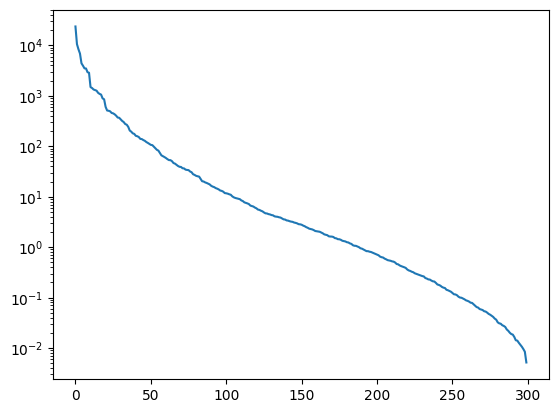

iter 0, loss -9974.9892578125
iter 1, loss -19746.384765625
iter 2, loss -29320.115234375
iter 3, loss -38700.98828125
iter 4, loss -47893.3671875
iter 5, loss -56901.3359375
iter 6, loss -65728.8125
iter 7, loss -74379.5625
iter 8, loss -82857.2265625
iter 9, loss -91165.40625
iter 10, loss -99307.5234375
iter 11, loss -107286.9765625
iter 12, loss -115107.0546875
iter 13, loss -122770.9921875
iter 14, loss -130281.953125
iter 15, loss -137643.0
iter 16, loss -144857.125
iter 17, loss -151927.40625
iter 18, loss -158856.5625
iter 19, loss -165647.5625
iter 20, loss -172303.078125
iter 21, loss -178825.90625
iter 22, loss -185218.640625
iter 23, loss -191483.953125
iter 24, loss -197624.34375
iter 25, loss -203642.265625
iter 26, loss -209540.359375
iter 27, loss -215320.75
iter 28, loss -220986.015625
iter 29, loss -226538.40625
iter 30, loss -231980.0625
iter 31, loss -237313.359375
iter 32, loss -242540.21875
iter 33, loss -247663.09375
iter 34, loss -252683.84375
iter 35, loss -257

In [20]:
with torch.no_grad():
    a = gd(K_ij, b, lambd, a0, rho, eta, r, max_iter, device)